## Introduction

This Notebook contains implementaions of a few basic policy gradient algorithms.

The implementaions here use non-linear function approximation through Neural Networks.

The graph for training loss and agent performance are written to Tensorboard.

Have Fun!

#### Note: Unlike the linear function approximation texhniques seen earlier, the hyperparameters here in neural networks are more sensitive. Thus a good amount of tuning is required to get a decent performance.

In [1]:
%matplotlib inline

import numpy as np
import gym
from tqdm import tqdm

from pg_agents import REINFORCE, REINFORCE_Baseline, ActorCritic
from plots import plot_var_history
from torch.utils.tensorboard import SummaryWriter

import torch
import torch.nn as nn

from IPython.core.debugger import set_trace

## Available Agents
        - REINFORCE 
        - REINFORCE with Baseline
        - Actor-Critic
## Hyperparameters
### Neural Network:
        - Network Architecture
        - Learning Rate
        - Activation
### Algorithm
        - Advantage Function
        - Batch Size

In [2]:
def get_model_name(parameter_dict , critic=False):
    pol_hid_lyrs = ''.join(str(parameter_dict.get("pol_hid_lyrs")).split(','))
    pol_lr = parameter_dict.get("pol_lr")
    decay = parameter_dict.get("lr_decay", 1)
    if critic:
        val_hid_lyrs = ''.join(str(parameter_dict.get("val_hid_lyrs")).split(','))
        val_lr = parameter_dict.get("val_lr")
    batch_size = parameter_dict.get("batch_size")
    if not critic:
        name = 'actor_hid_{0}_lr_{1}_decay_{2}_batch_{3}'.format(pol_hid_lyrs, pol_lr, decay, batch_size)
    else:
        name = 'actor_hid_{0}_lr_{1}_critic_hid_{2}_lr_{3:.0e}_decay_{4}_batch_{5}'.format(pol_hid_lyrs, pol_lr, val_hid_lyrs, val_lr, decay, batch_size)
    return name

In [3]:
def run_experient(env, num_runs, num_episodes, agent_args, tb_path=None,
            render_env = False, plot_value_func = False, plot_state_visit = False):
    reward_history = []
    agents_hist = []
    state_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0] if isinstance(env.action_space, gym.spaces.Box) else env.action_space.n
    for i, (Agent, agent_kwargs) in enumerate(agent_args):
        reward_history.append([])
        # Start the runs for each setting
        for run in tqdm(range(1, num_runs+1), desc="Parameter Setting {}".format(i+1)):
            reward_history[i].append([])
            env.seed(run)
            epoch = 0
            agent_kwargs["seed"] = run
            agent = Agent(state_dim, act_dim, **agent_kwargs)
            if run == 1 and tb_path:
                model_name = get_model_name(agent_kwargs, critic=agent.baseline)
                writer = SummaryWriter(tb_path + '/' + agent.__str__() + '/' + model_name)
            # Start the episodes
            for episode in range(1, num_episodes+1):
                observation  = env.reset()
                done = False
                time_step = 0
                action = agent.start(observation)
                # Start interaction with environment
                while not done:
                    if render_env:
                        env.render()
                    # Take a step in the environment
                    observation, reward, done, info = env.step(action)
                    time_step +=1
                    if not done:
                        # Get next action from agent
                        action = agent.take_step(reward, observation)
                    else:
                        episode_reward, actor_loss, critic_loss = agent.end(reward)
                        reward_history[i][run-1].append(episode_reward)
                        if run == 1 and tb_path:
                            writer.add_scalar('Reward', episode_reward, episode)
                            if actor_loss:
                                epoch += 1
                                writer.add_scalar('Actor Loss', actor_loss, epoch)
                                writer.add_scalar('Episode Number', episode, epoch)
                                if critic_loss:
                                    writer.add_scalar('Critic Loss', critic_loss, epoch)
            if run == 1:
                agents_hist.append(agent)
                if tb_path:
                    writer.close()
    env.close()
    return reward_history, agents_hist

In [4]:
# Setup Cart Pole environment
Environment = 'CartPole-v1'
cart_pole_env = gym.make(Environment)

### Baseline:

The raw vanilla policy gradient update increases/decreases the probability of each trajectory proportional to the returns. If the reward is positive, the probability of the corresponding path is increased. If the reward is negative, the probability of the corresponding path is decreased. But say, all trajectories recieve a positive reward of different magnitude. In this case, the probability of all trajectories is increased with different weights (proportional to the reward). An intuitive idea is to increase the probability of more rewarding paths and decrease the probability of less rewarding paths. To achive this, a baseline can be subtracted from the returns. It can also be proved mathematically that this subtraction does not introduce any bias. Using a baseline reduces the variance and consequently accelrates the convergence.


### Actor-Critic methods:

In the earlier case, the target towards which we made updates were the Monte Carlo returns. Instead, we can make updates againt the temporal returns using bootstrapping. Similar to the tabular case, there are different methods to bootstrap to different degrees. One popular method is the Generalized Advantage Estimation (GAE) by Schulman et al. ([Paper](https://arxiv.org/abs/1506.02438)) THis technique is similar to lambda return updates used in the value function approximation setting.

### Experiment:

The below experiment compares the following three algorithms

1. REINFORCE
2. REINFORCE with Baseline
3. Actor-Critic


#### Important Note:
Though the policy updates are made against the bootstrapped returns, the updates for the value function are made against the Monte Carlo returns. Using bootstrapped returns for updating both the policy and value funtion caused the performance to diverge. I believe this can be thought of as, a case in which the agent tries to chase its own tail.

Note that the neural network used to approximate the value fuction must be big enough to represent it efficiently. Using a very small network causes slower learning and may converge to a cruder local optima.

In [5]:
# Experiment Settting
settings = [(REINFORCE, {'pol_hid_lyrs': [16, 16], 'lr_decay': 0.99, 'pol_lr': 0.01,
                         'min_pol_lr':0.001, 'batch_size': 5000, 'is_discrete': True}),
            (REINFORCE_Baseline,
             {'pol_hid_lyrs': [16, 16], 'val_hid_lyrs': [16, 32, 16], 'lr_decay': 0.99,
              'pol_lr': 0.01, 'min_pol_lr': 0.001, 'val_lr': 0.02, 'min_val_lr': 0.002, 
              'batch_size': 5000, 'is_discrete': True}),
            (ActorCritic,
             {'pol_hid_lyrs': [16, 16], 'val_hid_lyrs': [16, 32, 16], 'lr_decay': 0.99,
              'pol_lr': 0.01, 'min_pol_lr': 0.001, 'val_lr': 0.02, 'min_val_lr': 0.002, 
              'batch_size': 5000, 'is_discrete': True})]

# Setup Tensorboard path 
writer_path = '../runs/' + Environment

reward_hist_1, agent_hist_1 = run_experient(cart_pole_env, 25, 1500, settings, render_env=False, tb_path=writer_path)

Parameter Setting 3: 100%|██████████| 25/25 [1:31:34<00:00, 219.79s/it]


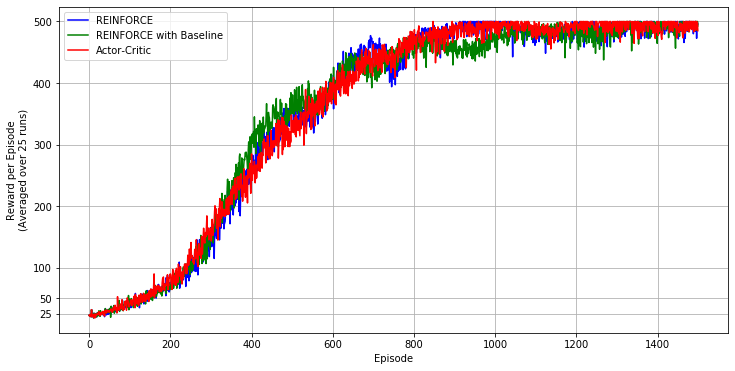

In [6]:
# Plot Results
plot_args = {'x_label': 'Episode', 'y_label': 'Reward per Episode\n(Averaged over 25 runs)',
            'log_scale': False, 'y_ticks': [25, 50, 100, 200, 300, 400, 500]}

labels = ["REINFORCE", "REINFORCE with Baseline", "Actor-Critic"]

plot_var_history(reward_hist_1, labels, **plot_args)

In [ ]:
# Experiment Settting
settings = [(REINFORCE, {'pol_hid_lyrs': [16, 16], 'lr_decay': 0.99, 'pol_lr': 0.01,
                         'min_pol_lr':0.001, 'batch_size': 5000, 'is_discrete': True}),
            (REINFORCE_Baseline,
             {'pol_hid_lyrs': [16, 16], 'val_hid_lyrs': [16, 32, 16], 'lr_decay': 0.99,
              'pol_lr': 0.02, 'min_pol_lr': 0.001, 'val_lr': 0.04, 'min_val_lr': 0.002, 
              'batch_size': 5000, 'is_discrete': True}),
            (ActorCritic,
             {'pol_hid_lyrs': [16, 16], 'val_hid_lyrs': [16, 32, 16], 'lr_decay': 0.99,
              'pol_lr': 0.02, 'min_pol_lr': 0.001, 'val_lr': 0.04, 'min_val_lr': 0.002, 
              'batch_size': 5000, 'is_discrete': True})]

# Setup Tensorboard path 
writer_path = '../runs/' + Environment

reward_hist_2, agent_hist_2 = run_experient(cart_pole_env, 2, 1500, settings, render_env=False, tb_path=writer_path)